# notebook for data merging 
# *Panopea* transcriptome

In [1]:
from Bio import SeqIO, AlignIO
from Bio import SeqIO, SwissProt
from Bio.SeqUtils import GC, GC_skew
from Bio.SeqRecord import SeqRecord

from pandas import Series, DataFrame
import pandas as pd

import pylab
import matplotlib.pyplot as plt 

import numpy as np
from numpy import *

In [2]:
def cpg(secuencia):
    g= secuencia.count("G")
    c= secuencia.count("C")
    cg= secuencia.count("CG")
    lar= len(secuencia)
    cpG=0
    try:
        g*c==0
    except:
        cpG=0
    else:
        if g == 0 or c== 0:
            cpG =0
        else:
            cpG=(round(cg/(g*c)*(lar**2/(lar-1)) ,8))
    return (cpG)

In [3]:
f = open('../panopea_data/data-results/Geoduck-transcriptome-v3.fa', 'r')

In [4]:
sizes = [(rec.name, len(rec), round(GC(rec.seq),4), cpg(rec.seq)) for rec in SeqIO.parse(f, "fasta")]
#f.close()
sizesdataf= DataFrame(sizes,columns= ["ContigID", "length", "GC", "CpG"] )
sizesdataf.head()

,ContigID,length,GC,CpG
0,comp100000_c0_seq1,453,33.9956,0.919033
1,comp100001_c1_seq1,493,30.4260,0.264219
2,comp100001_c2_seq1,558,30.6452,0.233631
3,comp100002_c0_seq1,208,40.8654,0.985872
4,comp100004_c1_seq1,276,31.5217,0.439224


In [5]:
sizesdataf.describe()

,length,GC,CpG
count,153982.000000,153982.000000,153982.000000
mean,660.440233,36.034563,0.547723
std,765.421464,6.727696,0.323846
min,201.000000,13.043500,0.000000
25%,253.000000,31.065650,0.323447
50%,372.000000,34.905700,0.492127
75%,734.000000,40.390000,0.727148
max,18024.000000,84.386600,3.514344


It should give these results

|	|length|GC content	|CpG|
|---|------|--|---------|---|
|count	|153982.000000	|153982.000000	|153982.000000|
|mean	|660.440233	|36.034563	|0.547723|
|std	|765.421464	|6.727696	|0.323846|
|min	|201.000000	|13.043500	|0.000000|
|25%	|253.000000	|31.065650	|0.323447|
|50%	|372.000000	|34.905700	|0.492127|
|75%	|734.000000	|40.390000	|0.727148|
|max	|18024.000000	|84.386600	|3.514344|

In [6]:
%matplotlib inline

#### sequences description from notebook
*01-Geoduck-fasta-v3.ipynb*

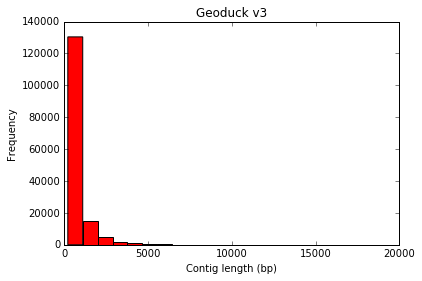

In [7]:
ax= plt.gca()
ax.hist(sizesdataf['length'], bins=20, color = 'r')
ax.set_xlabel('Contig length (bp)')
ax.set_ylabel('Frequency')
ax.set_title (r"Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3length.png")
plt.show()

### log10 transformation

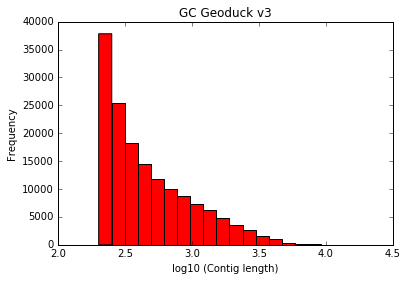

In [8]:
ax= plt.gca()
ax.hist(np.log10(sizesdataf['length']), bins=20, color = 'r')
ax.set_xlabel('log10 (Contig length)')
ax.set_ylabel('Frequency')
ax.set_title (r"GC Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3loglength.png")
plt.show()

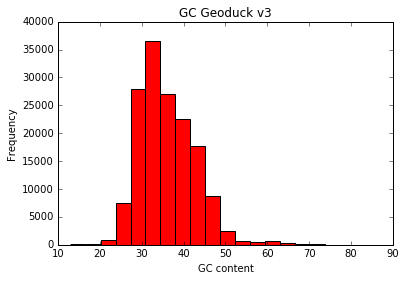

In [9]:
ax= plt.gca()
ax.hist(sizesdataf['GC'], bins=20, color = 'r')
ax.set_xlabel('GC content')
ax.set_ylabel('Frequency')
ax.set_title (r"GC Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3gc.png")
plt.show()

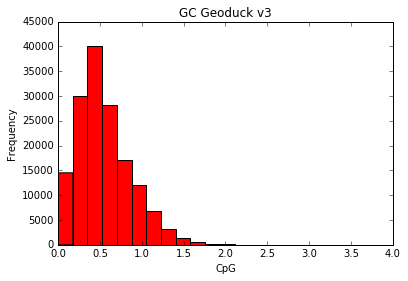

In [10]:
ax= plt.gca()
ax.hist(sizesdataf['CpG'], bins=20, color = 'r')
ax.set_xlabel('CpG')
ax.set_ylabel('Frequency')
ax.set_title (r"GC Geoduck v3")
#plt.savefig("../img/Geoduck-transcriptome-v3gc.png")
plt.show()

# Adding Blast results

In [11]:
encabezado =("ContigID", "sseqid1", "sseqid2", "sseqid3", "pident", "Length", "mismatch", "gapopen", "qstart", 
             "qend", "sstart","send", "Evalue", "bitscore",)
f_blastx = pd.read_csv ("../panopea_data/data-results/Geoduck-tranv3-blastx_sprot.sorted", delimiter=" ", 
                        index_col=None, names= encabezado, header= None)
f_blastx.sort_values(by ="ContigID")
f_blastx.head(2)

,ContigID,sseqid1,sseqid2,sseqid3,pident,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore
0,comp100065_c0_seq1,sp,Q5PRC1,LHFP_DANRE,48.00,50,26,0,151,2,100,149,2.000000e-08,51.6
1,comp100097_c0_seq1,sp,Q9UI26,IPO11_HUMAN,41.05,229,130,3,2,679,699,925,2.000000e-37,144.0


### finding whether the sequence is in the complimentary strand and saving it in the "strand" column

In [12]:
secuencias = []
n=0 
linea = ''
for row in f_blastx.index:
    rows= f_blastx.ix[row]
    if rows["qend"]-rows["qstart"]<0:
        linea=rows["ContigID"],-1
    else:
        linea= rows["ContigID"],1
    secuencias.append( linea)
    n+=1

secuencias = pd.DataFrame(secuencias, columns=['ContigID', 'strand'])
secuencias.head()

,ContigID,strand
0,comp100065_c0_seq1,-1
1,comp100097_c0_seq1,1
2,comp100104_c2_seq1,1
3,comp100105_c1_seq1,-1
4,comp100108_c1_seq1,1


In [13]:
f_blastx = pd.merge(f_blastx, secuencias, on= "ContigID")
f_blastx.head()

,ContigID,sseqid1,sseqid2,sseqid3,pident,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,strand
0,comp100065_c0_seq1,sp,Q5PRC1,LHFP_DANRE,48.00,50,26,0,151,2,100,149,2.000000e-08,51.6,-1
1,comp100097_c0_seq1,sp,Q9UI26,IPO11_HUMAN,41.05,229,130,3,2,679,699,925,2.000000e-37,144.0,1
2,comp100104_c2_seq1,sp,Q9NZJ4,SACS_HUMAN,47.83,138,58,4,2,397,2586,2715,3.000000e-29,118.0,1
3,comp100105_c1_seq1,sp,P18756,ETS1B_XENLA,85.71,126,18,0,402,25,143,268,2.000000e-73,233.0,-1
4,comp100108_c1_seq1,sp,Q9U943,APLP_LOCMI,32.45,413,227,9,4,1104,514,920,3.000000e-59,214.0,1


### Adding GO-ID, GO description and Protein names

In [14]:
f_annotation = pd.read_csv ("../panopea_data/data-results/Geoduck_v3_uniprot_wGO.csv", index_col=None)
f_annotation.sort_values(by ="ContigID")
f_annotation.head(2)

,ContigID,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names
0,comp100065_c0_seq1,2.000000e-08,Q5PRC1,GO:0016021,integral to membrane,Lipoma HMGIC fusion partner homolog
1,comp100097_c0_seq1,2.000000e-37,Q9UI26,GO:0005737; GO:0005634; GO:0008565; GO:0006610,cytoplasm; nucleus; protein transporter activi...,Importin-11 (Imp11) (Ran-binding protein 11) (...


In [15]:
#checking data
len(sizesdataf), len(f_blastx), len(f_annotation)

(153982, 22974, 22974)

In [16]:
f1= pd.merge(f_annotation, f_blastx, on= "ContigID", how="inner")
f1.head(2)

,ContigID,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,sseqid2,sseqid3,pident,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,strand
0,comp100065_c0_seq1,2.000000e-08,Q5PRC1,GO:0016021,integral to membrane,Lipoma HMGIC fusion partner homolog,sp,Q5PRC1,LHFP_DANRE,48.00,50,26,0,151,2,100,149,2.000000e-08,51.6,-1
1,comp100097_c0_seq1,2.000000e-37,Q9UI26,GO:0005737; GO:0005634; GO:0008565; GO:0006610,cytoplasm; nucleus; protein transporter activi...,Importin-11 (Imp11) (Ran-binding protein 11) (...,sp,Q9UI26,IPO11_HUMAN,41.05,229,130,3,2,679,699,925,2.000000e-37,144.0,1


In [17]:
len(f1),len(sizesdataf), len(f_annotation), len(f_blastx)

(22974, 153982, 22974, 22974)

In [18]:
f2= pd.merge(sizesdataf, f1, on= "ContigID", how="outer")
f2.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,strand
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
len(f2),len(sizesdataf), len(f_annotation), len(f_blastx)

(153982, 153982, 22974, 22974)

In [20]:
f2.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,Length,mismatch,gapopen,qstart,qend,sstart,send,Evalue,bitscore,strand
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Adding expression data

In [21]:
f_exp = pd.read_csv ("../panopea_data/data-results/Male-v-Female-Expression.csv", index_col=None)
f_exp.head()

,FeatureID,range,difference,fold_change,male_unique,male_total,female_unique,female_total
0,comp144588_c2_seq1,20506477,-20506477,-3.426534,28957409,28957409,8450932,8450932
1,comp144588_c3_seq1,19963924,-19963924,-3.796427,27102977,27103006,7139078,7139082
2,comp144588_c4_seq1,15492666,-15492666,-3.083767,22927597,22927597,7434931,7434931
3,comp144588_c1_seq1,822446,-822446,-3.120936,1210217,1210221,387774,387775
4,comp128741_c0_seq1,338448,-338448,-25.461405,352284,352284,13836,13836


In [22]:
len(f_exp)

154407

### the file Male-v-Female-Expression.csv
seems to have the data from all contigs including the non-eukaryote

In [23]:
f_exp = f_exp.rename(columns={"FeatureID" : 'ContigID'})
del f_exp['male_total']
del f_exp['range']
del f_exp['difference']
del f_exp['female_total']
f_exp.head()

,ContigID,fold_change,male_unique,female_unique
0,comp144588_c2_seq1,-3.426534,28957409,8450932
1,comp144588_c3_seq1,-3.796427,27102977,7139078
2,comp144588_c4_seq1,-3.083767,22927597,7434931
3,comp144588_c1_seq1,-3.120936,1210217,387774
4,comp128741_c0_seq1,-25.461405,352284,13836


In [24]:
f3 = pd.merge(f2, f_exp, on= "ContigID", how='inner')
f3.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,qstart,qend,sstart,send,Evalue,bitscore,strand,fold_change,male_unique,female_unique
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.571429,7,11
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.500000,2,49
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.714286,7,82
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,6
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7,0


In [25]:
len(f3)

153982

In [26]:
len(f2), len(f3)

(153982, 153982)

# Calculating the expression and male and female features

In [27]:
mafa=[]
linea=''
n=200
for rows in f3.index:
    row= f3.ix[rows]
    linea=''
    if row["fold_change"]>100 and row['female_unique']>200 and row['male_unique']!=0:
        linea= row['ContigID'],"female>male" 
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'female>male')
    elif row["fold_change"]<-100 and row['male_unique']>200 and row['female_unique']!=0:
        linea= row['ContigID'],"male>female" 
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'male>female')
    elif row["fold_change"]>100 and row['female_unique']>200 and row['male_unique']==0:
        linea= row['ContigID'],"female" 
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'female')
    elif row["fold_change"]<-100 and row['male_unique']>200 and row['female_unique']==0:
        linea= row['ContigID'],"male"
        #print (row['male_unique'],row['female_unique'],row["fold_change"], 'male')
    else:
        linea= row['ContigID'],""
    mafa.append(linea)

mafa= pd.DataFrame(mafa, columns=['ContigID', 'sex'])
mafa.describe()        
mafa.groupby('sex')['ContigID'].count()

sex
               153430
female             42
female>male       339
male               35
male>female       136
Name: ContigID, dtype: int64

In [28]:
f4 = pd.merge(f3, mafa, on= "ContigID")
f4.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,qend,sstart,send,Evalue,bitscore,strand,fold_change,male_unique,female_unique,sex
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.571429,7,11,
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.500000,2,49,
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.714286,7,82,
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,6,
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7,0,


In [29]:
del f4['fold_change']
f4.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,qstart,qend,sstart,send,Evalue,bitscore,strand,male_unique,female_unique,sex
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,11,
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,49,
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,82,
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0,


In [30]:
f4.groupby('sex')['ContigID'].count()

sex
               153430
female             42
female>male       339
male               35
male>female       136
Name: ContigID, dtype: int64

#### these are the only female, male or differential expression data

## adding Gigaton, *Ruphi* and Dh data

In [31]:
f_exp = pd.read_table ("../panopea_data/data-results/Master-SP-Gig-Ruphi_Dh.txt", index_col=None, engine='python')
f_exp.head()

,Pgen-ID,evalue-SP,SPID,ProteinName,Organism,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp123774_c0_seq1,0.000000e+00,P06603,Tubulin alpha-1 chain,Drosophila melanogaster (Fruit fly),antimicrobial humoral response [GO:0019730]; m...,PF00091;PF03953;,0.000000e+00,CHOYP_RABGAP1.1.1,0.000000e+00,ruditapes2_c97,0.000000e+00,AJ431728.p.cg.6,6.0,male gonad
1,comp140491_c1_seq2,1.000000e-119,Q25410,Putative molluscan insulin-related peptide(s) ...,Lymnaea stagnalis (Great pond snail) (Helix st...,transmembrane receptor protein tyrosine kinase...,PF00041;PF00757;PF07714;PF01030;,2.000000e-104,CHOYP_MIPR.1.2,NaN,NaN,1.000000e-101,AJ535669.p.cg.6,2.0,NaN
2,comp142230_c1_seq2,9.000000e-131,Q8MPM1,Gelsolin-like protein 2 (Actin-modulator) (EWA...,Lumbricus terrestris (Common earthworm),actin filament capping [GO:0051693],PF00626;,2.000000e-79,CHOYP_LOC100371249.1.1,NaN,NaN,7.000000e-74,AJ563467.p.cg.6,4.0,NaN
3,comp144511_c0_seq9,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,CHOYP_ANLN.1.1,NaN,NaN,2.000000e-116,AM237648.p.cg.6,7.0,NaN
4,comp139165_c0_seq2,0.000000e+00,P07201,Ribonucleoside-diphosphate reductase small cha...,Spisula solidissima (Atlantic surf-clam),deoxyribonucleoside diphosphate metabolic proc...,PF00268;,0.000000e+00,CHOYP_RIR2.1.1,4.000000e-86,ruditapes_c11036,5.000000e-83,AM237649.p.cg.6,9.0,NaN


In [32]:
f_exp = f_exp.rename(columns={"Pgen-ID" : 'ContigID'})
f_exp.head()

,ContigID,evalue-SP,SPID,ProteinName,Organism,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp123774_c0_seq1,0.000000e+00,P06603,Tubulin alpha-1 chain,Drosophila melanogaster (Fruit fly),antimicrobial humoral response [GO:0019730]; m...,PF00091;PF03953;,0.000000e+00,CHOYP_RABGAP1.1.1,0.000000e+00,ruditapes2_c97,0.000000e+00,AJ431728.p.cg.6,6.0,male gonad
1,comp140491_c1_seq2,1.000000e-119,Q25410,Putative molluscan insulin-related peptide(s) ...,Lymnaea stagnalis (Great pond snail) (Helix st...,transmembrane receptor protein tyrosine kinase...,PF00041;PF00757;PF07714;PF01030;,2.000000e-104,CHOYP_MIPR.1.2,NaN,NaN,1.000000e-101,AJ535669.p.cg.6,2.0,NaN
2,comp142230_c1_seq2,9.000000e-131,Q8MPM1,Gelsolin-like protein 2 (Actin-modulator) (EWA...,Lumbricus terrestris (Common earthworm),actin filament capping [GO:0051693],PF00626;,2.000000e-79,CHOYP_LOC100371249.1.1,NaN,NaN,7.000000e-74,AJ563467.p.cg.6,4.0,NaN
3,comp144511_c0_seq9,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,CHOYP_ANLN.1.1,NaN,NaN,2.000000e-116,AM237648.p.cg.6,7.0,NaN
4,comp139165_c0_seq2,0.000000e+00,P07201,Ribonucleoside-diphosphate reductase small cha...,Spisula solidissima (Atlantic surf-clam),deoxyribonucleoside diphosphate metabolic proc...,PF00268;,0.000000e+00,CHOYP_RIR2.1.1,4.000000e-86,ruditapes_c11036,5.000000e-83,AM237649.p.cg.6,9.0,NaN


In [33]:
f5 = pd.merge(f4, f_exp)
f5.head()

,ContigID,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,...,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
0,comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## saving big table

In [34]:
f5.to_csv("../panopea_data/data-results/Geoduck-transcriptome_v3_bigtablefinal.csv",index=None)

### setting "ContigID" column as index

In [34]:
f5.set_index(["ContigID"])

,length,GC,CpG,evalue,UniProt_Acc,Gene ontology IDs,Gene ontology (GO),Protein names,sseqid1,sseqid2,...,GO,PFAM,evalue-GIG,Gigaton-ID,evalue-Ru,Ruphibase_ID,evalue-SIG,SigID,Cluster,Tissue-enriched-expression
ContigID,,,,,,,,,,,,,,,,,,,,,
comp100000_c0_seq1,453,33.9956,0.919033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100001_c1_seq1,493,30.4260,0.264219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100001_c2_seq1,558,30.6452,0.233631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100002_c0_seq1,208,40.8654,0.985872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100004_c1_seq1,276,31.5217,0.439224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100007_c0_seq1,734,32.1526,0.689395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100010_c0_seq1,246,38.2114,1.136696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100011_c0_seq1,315,33.6508,0.562483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp100012_c0_seq1,218,35.3211,0.152087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## copying annotation "Protein names" to the fasta file

In [35]:
f = open('../panopea_data/data-results/Geoduck-transcriptome-v3.fa', 'r')
secuencias=[]
linea=''
n=1
for rec in SeqIO.parse(f, "fasta"):
    descripcion = str(f5.loc[f5["ContigID"]==rec.id]['Protein names'].values[0])
    if f5.loc[f5["ContigID"]==rec.id]['strand'].values[0]<1:
        secuencia=rec.seq.reverse_complement()
    else:
        secuencia=rec.seq
    if descripcion != "nan" :
        linea =SeqRecord(secuencia, id=rec.id, description="PREDICTED "+descripcion[:]+
                         " [Panopea generosa]")
    else :
        linea =SeqRecord(secuencia, id=rec.id, description=rec.id)#rec.description)
    secuencias.append(linea)
    if n%1000==0 and n<10000:
        print ("processing sequence ",n, "please wait")
        #break
    elif n%10000==0:
        print ("processing sequence ",n, "please wait")
    n+=1
print ("processing finished a total of  ",n, " sequences")

processing sequence  1000 please wait
processing sequence  2000 please wait
processing sequence  3000 please wait
processing sequence  4000 please wait
processing sequence  5000 please wait
processing sequence  6000 please wait
processing sequence  7000 please wait
processing sequence  8000 please wait
processing sequence  9000 please wait
processing sequence  10000 please wait
processing sequence  20000 please wait
processing sequence  30000 please wait
processing sequence  40000 please wait
processing sequence  50000 please wait
processing sequence  60000 please wait
processing sequence  70000 please wait
processing sequence  80000 please wait
processing sequence  90000 please wait
processing sequence  100000 please wait
processing sequence  110000 please wait
processing sequence  120000 please wait
processing sequence  130000 please wait
processing sequence  140000 please wait
processing sequence  150000 please wait
processing finished a total of   153983  sequences


In [39]:
SeqIO.write(secuencias, '../panopea_data/data-results/Geoduck-transcriptome-v3annotated.fa', 'fasta')

153982

## checking the number of sequences matched with Dh data

In [37]:
f5.groupby('Tissue-enriched-expression')['ContigID'].count()

Tissue-enriched-expression
adductor muscle     1
female gonad        9
male gonad         12
Name: ContigID, dtype: int64

## checking the number of sequences matched with Gigaton data

In [38]:
gigaton= f5.groupby('Gigaton-ID')['ContigID'].count()
len(gigaton)

7683

In [39]:
gigaton= f5.groupby('Organism')['ContigID'].count()
len(gigaton)

981

#### there are too many data to represent in a graph

## Checking how many columns there are in the big table

In [40]:
n, n1 = 0,1
for row in f5:
    print ( "%2i %-16s" % (n1,row), end="\t")
    n+=1
    n1+=1
    if n==4:
        print("")
        n=0

 1 ContigID        	 2 length          	 3 GC              	 4 CpG             	
 5 evalue          	 6 UniProt_Acc     	 7 Gene ontology IDs	 8 Gene ontology (GO)	
 9 Protein names   	10 sseqid1         	11 sseqid2         	12 sseqid3         	
13 pident          	14 Length          	15 mismatch        	16 gapopen         	
17 qstart          	18 qend            	19 sstart          	20 send            	
21 Evalue          	22 bitscore        	23 strand          	24 male_unique     	
25 female_unique   	26 sex             	27 evalue-SP       	28 SPID            	
29 ProteinName     	30 Organism        	31 GO              	32 PFAM            	
33 evalue-GIG      	34 Gigaton-ID      	35 evalue-Ru       	36 Ruphibase_ID    	
37 evalue-SIG      	38 SigID           	39 Cluster         	40 Tissue-enriched-expression	


### need to check columns for instance 
#### 6 UniProt_Acc,  11 sseqid2 and 28 SPID should be the same.
#### 9 Protein names and 29 ProteinName check if they have the same information

### can we eliminate some columns?
### checking columns "UniProt_Acc","sseqid2", "SPID"

In [41]:
n=0
nuni,nsse,nspid = 0,0,0
for rows in f5.index:
    row=f5.ix[rows]
    if  str(row["UniProt_Acc"])=="nan" and str(row["sseqid2"])=="nan" and  str(row["SPID"])=="nan":
        continue
    else:
        if row["UniProt_Acc"]!=row["sseqid2"] or row["UniProt_Acc"]!=row["SPID"]:
            print (row["ContigID"] , row["UniProt_Acc"], row["sseqid2"], row["SPID"])
            if str(row["UniProt_Acc"])=="nan":
                nuni+=1
            if str(row["sseqid2"])=="nan":
                nsse +=1
            if str(row["SPID"])=="nan":
                nspid+=1
            n+=1
print ("there are ", n, "non common values", "\n", "UniProt_Acc", nuni, "sseqid2", nsse, "SPID", nspid)

comp101491_c0_seq1 P66844 P66844 nan
comp102322_c0_seq2 nan Q05654 nan
comp102705_c0_seq1 O05313 O05313 nan
comp105389_c0_seq1 nan Q05654 nan
comp108023_c0_seq1 P64803 P64803 nan
comp108920_c0_seq1 nan Q05654 nan
comp109128_c0_seq1 P66952 P66952 nan
comp110590_c1_seq1 A8MQB9 A8MQB9 nan
comp113441_c0_seq1 P71667 P71667 nan
comp115918_c0_seq1 nan Q05654 nan
comp116601_c0_seq1 O42867 O42867 nan
comp116887_c0_seq2 A0PJM3 A0PJM3 nan
comp117365_c3_seq1 O05916 O05916 nan
comp120102_c0_seq1 O53454 O53454 nan
comp121908_c0_seq3 Q9P324 Q9P324 nan
comp123030_c0_seq1 Q6ZN80 Q6ZN80 nan
comp127569_c0_seq1 P53625 P53625 nan
comp128164_c0_seq1 P01744 P01744 nan
comp130401_c0_seq2 O69669 O69669 nan
comp130818_c1_seq2 P0A502 P0A502 nan
comp133943_c0_seq2 Q5TG08 Q5TG08 nan
comp134082_c0_seq1 Q6ZTY8 Q6ZTY8 nan
comp135800_c0_seq7 P63777 P63777 nan
comp135909_c0_seq2 P33765 P33765 nan
comp1363_c0_seq1 Q7D628 Q7D628 nan
comp136833_c0_seq1 O05871 O05871 nan
comp136898_c1_seq1 Q6ZTY8 Q6ZTY8 nan
comp137246_c1_s

### checking columns "UniProt_Acc","sseqid2", "SPID"

In [42]:
n=0
npn,npns = 0,0
for rows in f5.index:
    row=f5.ix[rows]
    if  str(row["Protein names"])=="nan" and str(row["ProteinName"])=="nan" :
        continue
    else:
        if row["Protein names"]!=row["ProteinName"] :
            print (row["ContigID"] , row["Protein names"], row["ProteinName"])
            if str(row["Protein names"])=="nan":
                npns+=1
            if str(row["ProteinName"])=="nan":
                npn +=1
            n+=1
print ("there are ", n, "non common values", "\n", "Protein names", npns, "ProteinName", npn)

comp100184_c0_seq2 Sphingosine-1-phosphate lyase (S1PL) (SP-lyase) (SPL) (EC 4.1.2.27) (Sphingosine-1-phosphate aldolase) Sphingosine-1-phosphate lyase (AtSPL1) (S1PL) (SP-lyase) (SPL) (EC 4.1.2.27) (Dihydrosphingosine phosphate lyase 1) (AtDPL1) (Sphingosine-1-phosphate aldolase)
comp100298_c0_seq1 Histidine-specific methyltransferase EgtD (EC 2.1.1.44) (Histidine-alpha-N-methyltransferase) Histidine N-alpha-methyltransferase (EC 2.1.1.44) (Histidine trimethyltransferase)
comp100442_c0_seq1 Sterol 26-hydroxylase, mitochondrial (EC 1.14.13.15) (5-beta-cholestane-3-alpha,7-alpha,12-alpha-triol 27-hydroxylase) (Cytochrome P-450C27/25) (Cytochrome P450 27) (Sterol 27-hydroxylase) (Vitamin D(3) 25-hydroxylase) Sterol 26-hydroxylase, mitochondrial (EC 1.14.15.15) (5-beta-cholestane-3-alpha,7-alpha,12-alpha-triol 27-hydroxylase) (Cytochrome P-450C27/25) (Cytochrome P450 27) (Sterol 27-hydroxylase) (Vitamin D(3) 25-hydroxylase)
comp100517_c1_seq1 Netrin receptor UNC5B (Protein unc-5 homolog 2

In [50]:
n=0
npn,npns = 0,0
for rows in f5.index:
    row=f5.ix[rows]
    if  str(row["Protein names"])=="nan" and str(row["ProteinName"])=="nan" :
        continue
    else:
        linea =row["ContigID"]
        if  str(row["Protein names"])=="nan":
            linea= linea+" --- "
        elif str(row["ProteinName"])=="nan":
            str(row["Protein names"][:20]), str(row["ProteinName"][:20])


        if  str(row["ProteinName"])!="nan":
            , str(row["Protein names"][:20]), str(row["ProteinName"][:20])
        if row["Protein names"]!=row["ProteinName" and  and ] :
            print ()
            if str(row["Protein names"])=="nan":
                npns+=1
            if str(row["ProteinName"])=="nan":
                npn +=1
            n+=1
print ("there are ", n, "non common values", "\n", "Protein names", npns, "ProteinName", npn)

comp100065_c0_seq1 Lipoma HMGIC fusion  Lipoma HMGIC fusion 
comp100097_c0_seq1 Importin-11 (Imp11)  Importin-11 (Imp11) 
comp100104_c2_seq1 Sacsin (DnaJ homolog Sacsin (DnaJ homolog
comp100105_c1_seq1 Protein c-ets-1-B (C Protein c-ets-1-B (C
comp100108_c1_seq1 Apolipophorins [Clea Apolipophorins [Clea
comp100109_c0_seq1 Alpha-tectorin Alpha-tectorin
comp100113_c0_seq1 Beta-1,3-galactosylt Beta-1,3-galactosylt
comp100113_c0_seq2 Beta-1,3-galactosylt Beta-1,3-galactosylt
comp100113_c1_seq1 Beta-1,3-galactosylt Beta-1,3-galactosylt
comp100129_c0_seq1 Ras GTPase-activatin Ras GTPase-activatin
comp100141_c0_seq1 Mitochondrial uncoup Mitochondrial uncoup
comp100174_c1_seq1 E3 ubiquitin-protein E3 ubiquitin-protein
comp100184_c0_seq2 Sphingosine-1-phosph Sphingosine-1-phosph
comp100187_c0_seq1 Protein OPI10 homolo Protein OPI10 homolo
comp100218_c0_seq1 General transcriptio General transcriptio
comp100298_c0_seq1 Histidine-specific m Histidine N-alpha-me
comp100305_c0_seq1 Alpha-galactosida

TypeError: 'float' object is not subscriptable

In [49]:
row["Protein names"]==row["ProteinName"]

False

In [47]:
row["ProteinName"]

nan